Install chencrafts:
`pip install chencrafts`

In [1]:
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
import qutip as qt
import chencrafts as cc

In [3]:
exp_params = {
    'E_Ja': 4.6,
    'E_Jb': 5.5,
    'E_Ca': 0.9,
    'E_Cb': 0.9,
    'E_J': 3,
    'E_C': 50,
    'ECm': 16.686114352392064,
    'E_L1': 2,
    'E_L2': 2,
    # 'E_La': 0.292,
    # 'E_Lb': 0.287,
    'E_La': 0.21,
    'E_Lb': 0.21,

    'flux_s': 0,
    'flux_c': 0.32,
}

para = exp_params
para["flux_a"] = 0.5 + para["flux_s"]
para["flux_b"] = 0.5 - para["flux_s"]

In [4]:
sim_params = {
    "qa_cutoff": 110,
    "qb_cutoff": 110,
    "p_cutoff": 110,
    "m_cutoff": 110,
    "qa_dim": 5,
    "qb_dim": 5,
    "p_dim": 5,
    "m_dim": 7,
}

In [6]:
circ_yaml = f"""
branches:
# qubit a
- ["JJ", 0, 1, E_Ja = {para["E_Ja"]}, E_Ca = {para["E_Ca"]}]
- ["L", 1, 2, E_La = {para["E_La"]}]

# coupler
- ["C", 0, 2, E_C = {para["E_C"]}]
- ["L", 0, 2, E_L1 = {para["E_L1"]}]
- ["C", 0, 3, E_C]
- ["L", 0, 3, E_L2 = {para["E_L2"]}]
- ["JJ", 2, 3, E_J = {para["E_J"]}, ECm = {para["ECm"]}]

# qubit b
- ["JJ", 0, 4, E_Jb = {para["E_Jb"]}, E_Cb = {para["E_Cb"]}]
- ["L", 3, 4, E_Lb = {para["E_Lb"]}]
"""

ftc = scq.Circuit(circ_yaml, from_file=False, use_dynamic_flux_grouping=True, generate_noise_methods=True)

trans_mat = np.linalg.inv([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, -1, 0],
    [0, 1, 1, 0],
])

brch = ftc.branches
ftc.configure(
    transformation_matrix=trans_mat, 
    system_hierarchy=[[1], [2], [[3], [4]]], 
    subsystem_trunc_dims=[
        sim_params["qa_dim"], 
        sim_params["qb_dim"],
        [sim_params["m_dim"] * 2, [
            sim_params["m_dim"], 
            sim_params["p_dim"]
        ]], 
    ],
    closure_branches=[
        brch[0], brch[7], brch[6]   # flux in junctions
    ],
    # closure_branches=[circ.branches[1], circ.branches[4]]   # flux in inductors
)
ftc.cutoff_ext_1 = sim_params["qa_cutoff"]
ftc.cutoff_ext_2 = sim_params["qb_cutoff"]
ftc.cutoff_ext_3 = sim_params["m_cutoff"]
ftc.cutoff_ext_4 = sim_params["p_cutoff"]

ftc.Φ1 = para["flux_a"]
ftc.Φ2 = para["flux_b"]
ftc.Φ3 = -para["flux_c"]

ftc.sym_hamiltonian()

<IPython.core.display.Latex object>

In [13]:
ftc.tphi_1_over_f_flux(common_noise_options=dict(i=3, j=0))

5144.3523491997685

In [20]:
a = ftc.eigenvals()
a-a[0]

array([0.      , 0.134265, 0.14146 , 0.252927, 4.437446, 4.562357])

## spectrum reproducee

In [5]:
from typing import Tuple

def find_sweetspot_by_spectrum(
    self,   # the ftc circuit
    flux_c = None, 
    evals_count=4,
    ftol = 1e-8,
    gtol = 1e-8,
    eps = 1e-11,
    mode = "l3",
    flux_s_bounds = [0, 0.1],
    flux_sb_bounds = None,      # if not None, flux_a and b are independent
    flux_c_bounds = [0.25, 0.3],
    run_num = 1,
    **kwargs
) -> Tuple[float, float, float]:
    
    def freq_ab(params, evals_count, mode):
        try:
            self.flux_a = 0.5 + params["flux_s"]
            self.flux_c = params["flux_c"]
            if flux_sb_bounds is None:
                self.flux_b = 0.5 - params["flux_s"]
            else:
                self.flux_b = 0.5 + params["flux_sb"]
        except Exception:
            self.Φ1 = 0.5 + params["flux_s"]
            if flux_sb_bounds is None:
                self.Φ2 = 0.5 - params["flux_s"]
            else:
                self.Φ2 = 0.5 + params["flux_sb"]
            self.Φ3 = params["flux_c"]

        eigs = self.eigenvals(evals_count)
        if mode == "l3":
            return eigs[3] - eigs[0]
        elif mode == "l1+l2":
            return eigs[1] + eigs[2] - 2 * eigs[0]
        elif mode == "l2-l1":
            return np.abs(eigs[2] - eigs[1])
        elif mode == "zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return abszz
        elif mode == "l1+l2+zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return eigs[1] + eigs[2] - 2 * eigs[0] + abszz
        else:
            raise ValueError("mode not supported")
        
    free_params = {"flux_s": flux_s_bounds, "flux_c": flux_c_bounds}
    if flux_sb_bounds is not None:
        free_params["flux_sb"] = flux_sb_bounds
    
    opt = cc.tb.Optimization(
        {}, free_params,
        freq_ab,
        optimizer="L-BFGS-B",
        target_kwargs={"evals_count": evals_count, "mode": mode},
        opt_options={"ftol": ftol, "gtol": gtol, "disp": False, "eps": eps, "maxls": 100}
    )

    if flux_c is not None:
        opt.fix(flux_c=flux_c)
    
    multi_opt = cc.tb.MultiOpt(opt)
    multi_traj = multi_opt.run(run_num)
    traj = multi_traj.best_traj()

    try:
        self.flux_a = 0.5 + traj.final_full_para["flux_s"]
        self.flux_c = traj.final_full_para["flux_c"]
        if flux_sb_bounds is None:
            self.flux_b = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.flux_b = 0.5 + traj.final_full_para["flux_sb"]
        
        return self.flux_a, self.flux_b, self.flux_c
    except Exception:
        self.Φ1 = 0.5 + traj.final_full_para["flux_s"]
        if flux_sb_bounds is None:
            self.Φ2 = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.Φ2 = 0.5 + traj.final_full_para["flux_sb"]
        self.Φ3 = traj.final_full_para["flux_c"]
        
        return self.Φ1, self.Φ2, self.Φ3


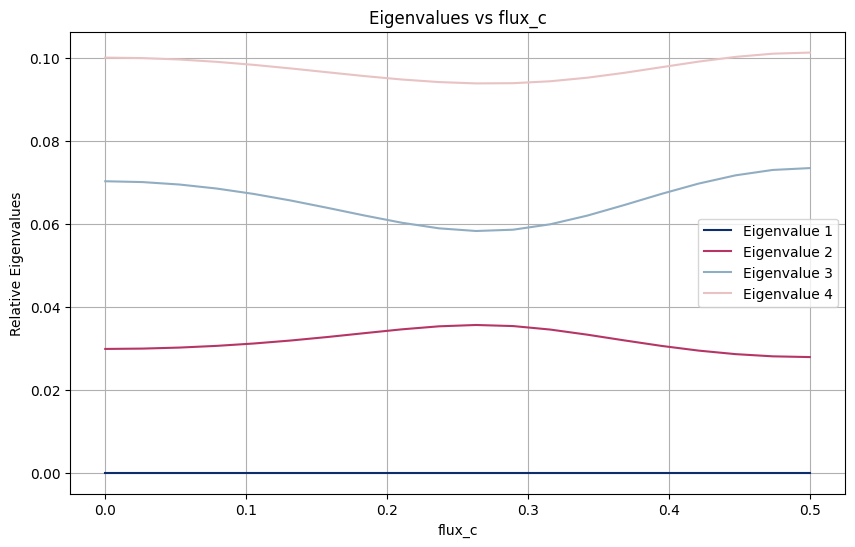

In [7]:
flux_c_values = np.linspace(0, 0.5, 20)  # Create 100 points between 0 and 0.5
evals_array = []

for flux_c in flux_c_values:
    phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=flux_c,
        flux_s_bounds=[-0.1, 0.1],
        run_num=1,
    )
    evals = ftc.eigenvals(4)
    evals_relative = evals - evals[0]
    evals_array.append(evals_relative)

evals_array = np.array(evals_array)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(flux_c_values, evals_array[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('flux_c')
plt.ylabel('Relative Eigenvalues')
plt.title('Eigenvalues vs flux_c')
plt.legend()
plt.grid(True)
plt.show()

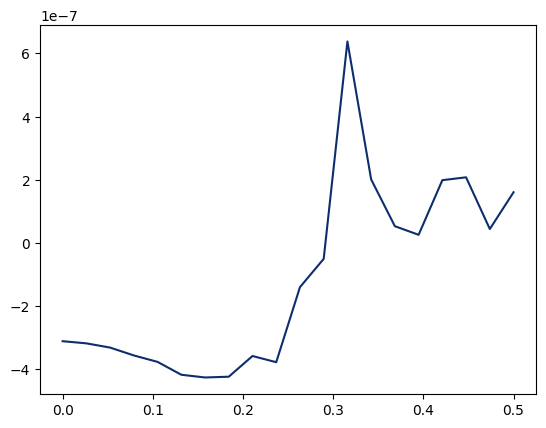

In [8]:
plt.plot(flux_c_values,evals_array[:, 3]-evals_array[:, 2]-evals_array[:, 1])
plt.show()

In [17]:
# #specify off position, specific choice of flux_c is from danny's paper
# phi1, phi2, phi3 = find_sweetspot_by_spectrum(
#         ftc, 
#         # flux_c=0.4,
#         flux_s_bounds=[-0.1, 0.1],
#         flux_c_bounds=[0.2,0.35],
#         run_num=1,
#     )
# print(phi1, phi2, phi3)
off = [0.4823500501369615,0.5176499498630385,0.2647067359584053]

## eff coupling reproduce

In [8]:

from joblib import Parallel, delayed


def calculate_H_eff(flux_c):
    phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=flux_c,
        flux_s_bounds=[-0.1, 0.1],
        run_num=1,
    )
    on = [phi1, phi2, phi3]

    off = [0.4823500501369615,0.5176499498630385,0.2647067359584053]
    ftc.Φ1, ftc.Φ2, ftc.Φ3 = off

    flux_shiftc = -(on[2]-off[2])
    flux_shift_a = on[0]-off[0]
    flux_shift_b = on[1] - off[1]

    hspace = ftc.hilbert_space
    dims = hspace.subsystem_dims
    hamiltonian = qt.Qobj(ftc.hamiltonian(), dims=[dims, dims])

    theta1_op = qt.Qobj(ftc.θ1_operator(), dims=[dims, dims])
    theta2_op = qt.Qobj(ftc.θ2_operator(), dims=[dims, dims])
    theta3_op = qt.Qobj(ftc.θ3_operator(), dims=[dims, dims])
    theta4_op = qt.Qobj(ftc.θ4_operator(), dims=[dims, dims])
    drive_c = (
        (ftc.E_La + ftc.E_Lb) / 2 * (theta1_op - theta2_op) / 2
        - (ftc.E_L1 + ftc.E_L2 + ftc.E_La + ftc.E_Lb) / 4 * theta3_op
    )
    drive_a = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta1_op+theta3_op+theta4_op)
    drive_b = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta2_op-theta3_op+theta4_op)

    evals, evecs = hamiltonian.eigenstates(hspace.dimension, tol=1e-10)

    subspace_state_idx = [0, 1, 2, 3]
    subspace1_evecs = [evecs[idx] for idx in subspace_state_idx]
    subspace2_evecs = [evec for idx, evec in enumerate(evecs) if idx not in subspace_state_idx]

    H_sw, _, _ = cc.cqed.block_diagonalize_pymablock(
        [hamiltonian, (flux_shift_a*drive_a + flux_shift_b*drive_b + flux_shiftc*drive_c)*2*np.pi],     
        subspace_eigenvectors=[subspace1_evecs, subspace2_evecs],
        atol=1e-10,
    )

    H_eff = 0
    for i in range(100):
        if np.linalg.norm(H_sw[0,0,i])<1e-8:
            break
        H_eff += H_sw[0,0,i]
    return np.abs(H_eff[1,2])

# Generate 20 flux_c values between 0.2 and 0.4
flux_c_values = np.linspace(0., 0.5, 6)

# Use joblib to parallelize the computation
results = Parallel(n_jobs=1)(delayed(calculate_H_eff)(flux_c) for flux_c in flux_c_values)



 /opt/anaconda3/envs/flux/lib/python3.12/site-packages/pymablock/block_diagonalization.py: 1091

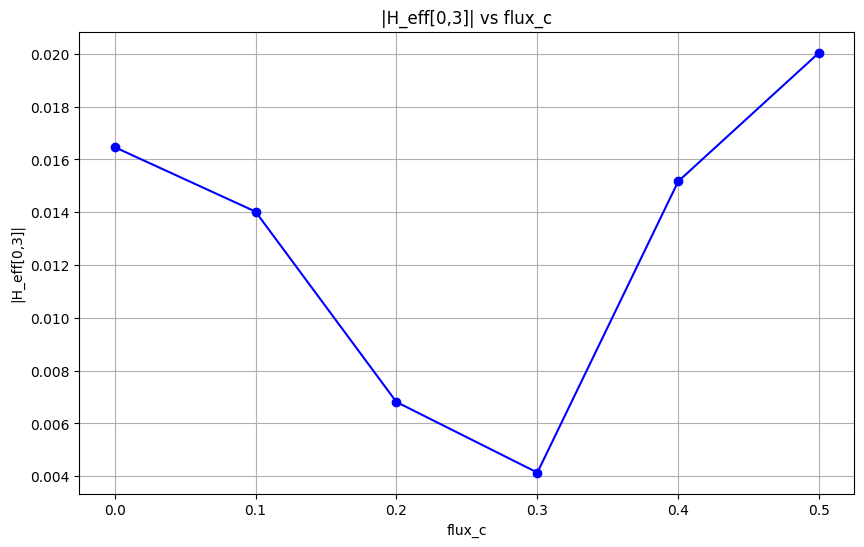

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(flux_c_values, results, 'b-o')
plt.xlabel('flux_c')
plt.ylabel('|H_eff[0,3]|')
plt.title('|H_eff[0,3]| vs flux_c')
# plt.ylim(-0.025,0.025)
plt.grid(True)
plt.show()

## check the charge operator in bare basis at ~0.27 sweet spot

In [6]:
ftc.Φ1, ftc.Φ2, ftc.Φ3 = [0.4823500501369615,0.5176499498630385,0.2647067359584053]
hamiltonian = ftc.hamiltonian().toarray()
charge_op3 = ftc.Q3_operator().toarray()
charge_op4 = ftc.Q4_operator().toarray()

In [25]:

phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        # flux_c=0.3,
        flux_s_bounds=[-0.1, 0.1],
        run_num=20,
        flux_c_bounds=[0.25,0.28],
        mode = "l1+l2"
    )

In [26]:
phi1, phi2, phi3

(0.48235440694628967, 0.5176455930537104, 0.2740731827162718)

In [27]:
import numpy as np

# Initialize parameters
ftc.Φ1, ftc.Φ2, ftc.Φ3 = [0.48235440694628967, 0.5176455930537104, 0.2740731827162718]
h = 1e-5  # Small step size for finite differences

# Compute original eigenvalues
evals = ftc.eigenvals() - ftc.eigenvals()[0]

# Function to compute the eigenvalues given parameters
def compute_evals(ftc):
    return ftc.eigenvals() - ftc.eigenvals()[0]

# Initialize the derivative matrix
derivative_matrix = np.zeros((3, 3))

# Compute derivatives w.r.t ftc.Φ1
ftc.Φ1 += h
evals_Φ1_plus = compute_evals(ftc)
ftc.Φ1 -= 2 * h
evals_Φ1_minus = compute_evals(ftc)
ftc.Φ1 += h  # Reset to original value

derivative_matrix[0, 0] = (evals_Φ1_plus[1] - evals_Φ1_minus[1]) / (2 * h)
derivative_matrix[1, 0] = (evals_Φ1_plus[2] - evals_Φ1_minus[2]) / (2 * h)
derivative_matrix[2, 0] = (evals_Φ1_plus[3] - evals_Φ1_minus[3]) / (2 * h)

# Compute derivatives w.r.t ftc.Φ2
ftc.Φ2 += h
evals_Φ2_plus = compute_evals(ftc)
ftc.Φ2 -= 2 * h
evals_Φ2_minus = compute_evals(ftc)
ftc.Φ2 += h  # Reset to original value

derivative_matrix[0, 1] = (evals_Φ2_plus[1] - evals_Φ2_minus[1]) / (2 * h)
derivative_matrix[1, 1] = (evals_Φ2_plus[2] - evals_Φ2_minus[2]) / (2 * h)
derivative_matrix[2, 1] = (evals_Φ2_plus[3] - evals_Φ2_minus[3]) / (2 * h)

# Compute derivatives w.r.t ftc.Φ3
ftc.Φ3 += h
evals_Φ3_plus = compute_evals(ftc)
ftc.Φ3 -= 2 * h
evals_Φ3_minus = compute_evals(ftc)
ftc.Φ3 += h  # Reset to original value

derivative_matrix[0, 2] = (evals_Φ3_plus[1] - evals_Φ3_minus[1]) / (2 * h)
derivative_matrix[1, 2] = (evals_Φ3_plus[2] - evals_Φ3_minus[2]) / (2 * h)
derivative_matrix[2, 2] = (evals_Φ3_plus[3] - evals_Φ3_minus[3]) / (2 * h)

# Print the derivative matrix
print("Derivative matrix:")
print(derivative_matrix)


Derivative matrix:
[[ 0.006819  0.000996 -0.007934]
 [-0.017628 -0.020479  0.008499]
 [-0.02407   0.020347  0.00088 ]]


In [12]:
# Extract the diagonal elements of the Hamiltonian and their indices
diag_elements = np.diag(hamiltonian)
indices = np.argsort(diag_elements)

# Sort the Hamiltonian matrix by rearranging rows and columns according to the sorted indices
sorted_hamiltonian = hamiltonian[np.ix_(indices, indices)]

# Apply the same rearrangement to the coupling matrix
charge_op3 = charge_op3[np.ix_(indices, indices)]
charge_op4 = charge_op4[np.ix_(indices, indices)]

In [13]:
evals,U = np.linalg.eigh(sorted_hamiltonian)
Ud = U.transpose().conjugate()


In [14]:
evals-evals[0]

array([0.000000e+00, 3.558536e-02, 5.823323e-02, 9.381833e-02, 4.399984e+00, 4.435574e+00, 5.024114e+00, 5.082360e+00,
       5.169787e+00, 5.205398e+00, 5.607070e+00, 5.665294e+00, 7.140239e+00, 7.172739e+00, 7.210144e+00, 7.217575e+00,
       9.424112e+00, 1.000703e+01, 1.019390e+01, 1.058294e+01, 1.077684e+01, 1.118058e+01, 1.118701e+01, 1.154628e+01,
       1.183719e+01, 1.220150e+01, 1.231453e+01, 1.278401e+01, 1.423831e+01, 1.516500e+01, 1.577584e+01, 1.578380e+01,
       1.608464e+01, 1.638528e+01, 1.656882e+01, 1.672399e+01, 1.720895e+01, 1.731337e+01, 1.740995e+01, 1.774225e+01,
       1.789288e+01, 2.036128e+01, 2.116244e+01, 2.128607e+01, 2.184698e+01, 2.209877e+01, 2.239689e+01, 2.257652e+01,
       2.269665e+01, 2.276512e+01, 2.276661e+01, 2.307325e+01, 2.329905e+01, 2.431619e+01, 2.691419e+01, 2.726710e+01,
       2.753494e+01, 2.773958e+01, 2.788984e+01, 2.807117e+01, 2.819688e+01, 2.852487e+01, 2.973637e+01, 2.977185e+01,
       2.979473e+01, 2.983021e+01, 3.016377e+01,

In [20]:
(Ud@charge_op3@U)[:4,:4]

array([[0.+2.334457e-17j, 0.-8.716518e-05j, 0.+1.437585e-04j, 0.-1.268180e-05j],
       [0.+8.716518e-05j, 0.+2.819479e-17j, 0.-3.499035e-06j, 0.+1.415612e-04j],
       [0.-1.437585e-04j, 0.+3.499035e-06j, 0.+2.776458e-17j, 0.-8.937458e-05j],
       [0.+1.268180e-05j, 0.-1.415612e-04j, 0.+8.937458e-05j, 0.+2.950420e-17j]])

In [18]:
(Ud@charge_op4@U)[:4,:4]

array([[0.+2.879912e-20j, 0.+1.279460e-05j, 0.+2.026237e-05j, 0.+6.114244e-08j],
       [0.-1.279460e-05j, 0.+5.733354e-20j, 0.-1.532716e-08j, 0.+2.058080e-05j],
       [0.-2.026237e-05j, 0.+1.532716e-08j, 0.+1.379605e-19j, 0.+1.247826e-05j],
       [0.-6.114244e-08j, 0.-2.058080e-05j, 0.-1.247826e-05j, 0.+4.053439e-19j]])